# Big project activity

## Optimal chargin station location

### 1.Introduction

Consider a long linear cycle path  as Vento, or the Danube cycle path. The cycle path usually runs along the banks of a river with scarse tourist interest. However, from the main course of the cycle path it is possible to reach places of tourist interest by making small detours.  

The rapid growth of e-bike ridership is proposing the problem of deploying a suitable charging infrastructure. The charging stations should be placed in strategic positions so as to guarantee a coverage of the whole cycle path. However, since the charging operations require a non negligible time, the charging station should be positioned in places where alternative activities could be carried out, as restaurants, museums, swimming pool, or other amenities. Moreover, the presence of a charging station could also induce e-cyclists to discover new places and generate positive externalities.



### 2.Decision problem
We can represent the cycle path as a graph where the set of nodes $H = \{1,\ldots,n\}$ corresponds to the tourist sites that may host a charging station.
In addition we are given the distances between touristic site ($d_{ij},$ with $ i,j =1,\ldots,n$). Let $c_i$ be the cost of installing a charging station in site $i, i=1\ldots,n$.


The problem is, given a budget $b$, determine the subset of sites $S\subseteq H$ where to install the charging stations so that the total cost is not higher than $b$ and the maximum distance between consecutive charging stations is minimized.
Consider that the cyclist has to visit all the touristic destination in a consecutive way.



### 3.Problem characteristics
There are 2 csv files that contain the information of the cycle way, they are essential to build the equivalent graph:


*    in the "nodes.csv" file there are all the destinations that the cyclist can reach, with their spatial coordinates and the value of installation costs related to that destination. Consider that the "tourist-dest-id" is not the graph node number but it is an unique id to identify the destination.
*   in the "OD.csv" you can find all the arcs between two different nodes, keep attention that the condition of visiting consecutive touristic destination must be respected.

The set of nodes $N$ is defined by $\{0,1,\ldots,n, n+1\}$.  The Arcs $A$ correspond to the portion of cycle path between two consecutive charging stations. We assume that potentially e-riders will visit all sites along the way making the suitable deviations and going back to the main path at the initial point of the detour.
The cost associated with each  arc $(i,j)$ is given by $c_j$, thus the cost of installing a charging station in $j$. These costs are defined for all arcs in $A$, while they are set to 0 for all the arcs that arrive in the last node.
The path starts in node $s = 0$ and ends in node $t = n+1$, these two nodes are connected to the nearest touristic site with an arc of null length.

### 4.Example of linear path with deviation
![picture](https://drive.google.com/uc?export=view&id=1w16bHtbu0FGGL-UntxeqxD7244D3eHbJ)

### 5.Requirements
The requirements of the problem are:


*   the maximum running time of the algorithm must be 5 minutes, so set the proper timer
*   create the equivalent graph and display it on a xy-plot
*   find the solution for the basic scenario, with a mip model, displaying the solution with a xy-plot, the budget constrain is $b = 10000\ € $.
*   Find the optimal solution for 5 different values of budget in the range $[10000, 100000]$. Select the values of the budget so as to have different charger locations.

  You have to motivate you choice and the solution you get. They can also be not common solution if they are well motivated. To support your decision and explanations you can print plots or tables. You can also compare different scenarios.


   
If you have some doubts related to the parametric analysis prof. Cubillos uploaded a notebook with the solution on WeBeeP and you can have a look there.

### Insert student name and student ID

student1:

ID1:

student2:

ID2:

student3

ID3:



In [105]:
#install libraries

#!pip install mip
#!pip install --upgrade cffi==1.15.0

In [106]:
#import libraries
import matplotlib as pl
import mip
import pandas as pd
import importlib
import cffi
importlib.reload(cffi)
import numpy as np
import math
import networkx as nx
import random
import time


In [107]:
#import the csv file
nodes_df = pd.read_csv("./nodes.csv", encoding='cp1252')
arcs_df = pd.read_csv("./OD.csv")

nodes_df.head()
arcs_df.head()

,origin_id,destination_id,distance [m]
0,0,0,NaN
1,0,17,43798.08450
2,0,18,47252.99168
3,0,20,57171.88493
4,0,21,62260.57345


In [108]:
#set the timer

#TO DO

[0, 90, 89, 88, 87, 85, 86, 82, 84, 83, 17, 18, 20, 21, 23, 77, 24, 25, 29, 30, 31, 32, 33, 35, 38, 39, 40, 41, 68, 69, 67, 64, 66, 63, 61, 62, 60, 48, 58, 57, 54, 53, 52, 36]


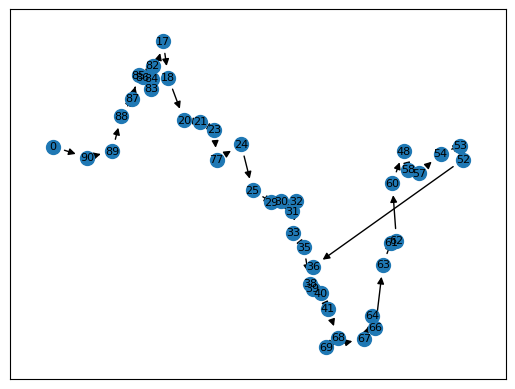

In [109]:
#build the equivalent graph

#define the set of nodes
N = set()
for index, node in nodes_df.iterrows():
    N.add(node.tourist_dest_id)

n = len(N)

#define the set of edges
def d(i, j):    # distance function
    if i == j: return 0
    res = arcs_df.loc[(arcs_df['origin_id'] == i) & (arcs_df['destination_id'] == j), 'distance [m]'].values[0]
    return res

def c(i, j):    # cost function
    if j == 91: return 0
    return nodes_df.loc[(nodes_df['tourist_dest_id'] == j), 'Cost_of_installation [€]'].values[0]

A = set()
for idx, arc in arcs_df.iterrows():
    i = int(arc.origin_id)
    j = int(arc.destination_id)
    A.add((i, j))
    
A_weighted = [(i, j, {'weight': d(i, j)}) for i, j in A]
#A_weighted += [ (0, 's', {'weight': 0}) ]
#A_weighted += [ (52, 't', {'weight': 0}) ]
#A_weighted += [('s', 't', {'weight': 0})]

#build the graph
G = nx.DiGraph()
G.add_nodes_from(N)
G.add_edges_from(A_weighted)

#pos = nx.circular_layout(G)    # another possible layout for nodes
pos = {id: (pos_x, pos_y) for id, pos_x, pos_y in nodes_df[['tourist_dest_id', 'x (longitude)', 'y (latitude)']].values}
nx.draw_networkx_nodes(G, pos=pos, node_size=100)
nx.draw_networkx_labels(G,pos=pos, font_size=8)

# TSP
# Hamiltonian cycle (path), found by using networkX library, and assuming first node is 0 and last node is 52 (by looking at the plot)
tsp = nx.approximation.traveling_salesman_problem
path = tsp(G, cycle=False, method=nx.approximation.greedy_tsp)

#path = nx.approximation.simulated_annealing_tsp(G, init_cycle='greedy', weight='weight', source=0, temp=100, move='1-0', max_iterations=10, N_inner=100, alpha=0.01, seed=random.randint(0, 1000))
#path = nx.approximation.greedy_tsp(G)

# plot the path
path_edges = [(path[i], path[i+1]) for i in range(len(path) - 1)]
G.add_edges_from(path_edges)

#draw the path
nx.draw_networkx_edges(G, edgelist=path_edges, pos=pos)
print(path)

In [110]:
# cost of a stage
def d_stage(i, j):
    i_idx, j_idx = path.index(i), path.index(j)
    if i_idx >= j_idx: return math.inf
    sub_path = path[i_idx:j_idx+1]
    return sum(d(sub_path[k], sub_path[k+1]) for k in range(len(sub_path)-1))

# create the logical graph
N_logical = N
A_logical = {}
for i in range(len(path)):
    for j in range(i+1, len(path)):
        A_logical[(path[i], path[j])] = d_stage(path[i], path[j])

print(A_logical)

{(0, 90): 16011.18979, (0, 89): 29832.45227, (0, 88): 34130.609288, (0, 87): 39610.193432, (0, 85): 43246.561147, (0, 86): 44815.590338, (0, 82): 49574.269353, (0, 84): 50930.539801000006, (0, 83): 51920.064284700005, (0, 17): 58858.1501167, (0, 18): 65882.9350267, (0, 20): 78071.4495667, (0, 21): 87632.4626397, (0, 23): 93243.0957797, (0, 77): 97561.0682007, (0, 24): 105549.4522637, (0, 25): 110946.6641737, (0, 29): 117959.8540277, (0, 30): 121300.0686557, (0, 31): 126593.9687337, (0, 32): 128768.65600070001, (0, 33): 132867.1843347, (0, 35): 137239.2808767, (0, 38): 144420.16352170001, (0, 39): 145890.58519970003, (0, 40): 149009.34618570004, (0, 41): 153401.86676370003, (0, 68): 158625.64165370003, (0, 69): 162738.27962670004, (0, 67): 174229.47066670004, (0, 64): 180159.49675070005, (0, 66): 182035.48160770006, (0, 63): 190281.46039870006, (0, 61): 194607.28054370006, (0, 62): 196241.31564870005, (0, 60): 204407.98176070006, (0, 48): 215250.14981070007, (0, 58): 218111.25002570008,

In [111]:
import mip
# Create model
m = mip.Model()

# define the variables
x = {(i, j): m.add_var(var_type=mip.BINARY) for (i, j) in A_logical}            # decisions: arc (i, j) belongs to the path
D = m.add_var()                                                                 # dummy variable for min-max linearization

#  define the contraints

m.add_constr( mip.xsum(x[(i, j)] for (i, j) in A_logical if i == 0) == 1 )      # source node -> 1 outgoing arc
m.add_constr( mip.xsum(x[(i, j)] for (i, j) in A_logical if j == 36) == 1 )     # destination node -> 1 ingoing arc

# two arcs or zero for each other node
for i in N:
  if i != 0 and i != 36:
    m.add_constr( mip.xsum(x[(n_in, n_out)] for n_in, n_out in A_logical if n_out == i)
                  - mip.xsum(x[(n_in, n_out)] for n_in, n_out in A_logical if n_in == i) == 0 )


budget = 10000
m.add_constr( mip.xsum(x[(i, j)] * c(i, j) for i, j in A_logical) <= budget )   # budget constraint

for (i, j) in A_logical:
  m.add_constr( D >= x[(i, j)] * A_logical[(i, j)] )                            # dummy variable constraint

# optimize objective function
m.objective = mip.minimize( D )

m.optimize()

Starting solution of the Linear programming relaxation problem using Dual Simplex

Coin0506I Presolve 991 (0) rows, 947 (0) columns and 4687 (-43) elements
Clp0014I Perturbing problem by 0.001% of 691.82399 - largest nonzero change 0.00053340065 ( 7.710063e-05%) - largest zero change 0.00053214704
Clp0006I 0  Obj 0 Primal inf 35.429855 (2)
Clp0000I Optimal - objective value 3353.604
Clp0032I Optimal objective 3353.603962 - 194 iterations time 0.002

Starting MIP optimization
Cgl0004I processed model has 991 rows, 947 columns (946 integer (946 of which binary)) and 4730 elements
Coin3009W Conflict graph built in 0.001 seconds, density: 0.254%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0045I Nauty did not find any useful orbits in time 0.012385
Cbc0038I Initial state - 120 integers unsatisfied sum - 2.70054
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 299615 iterations 143
Cbc0038I Solution found of 299615
Cbc0038I Relaxing continuous gives 299615
Cbc0038I Be

<OptimizationStatus.OPTIMAL: 0>

In [112]:
# print solution details
path_stages = []
print(f"Objective function (max distance between stops): {D.x}")
print(f"Total cost for this solution: {mip.xsum(x[(i, j)].x * c(i, j) for i, j in A_logical)} (budget: {budget})")

for t, x_i in x.items():
  if x_i.x != 0:
    path_stages.append(t)
stops = list(sum(path_stages, ()))
stops = list(dict.fromkeys(stops))

print("Stops selected:")
print(stops)

Objective function (max distance between stops): 61821.56584
Total cost for this solution: + 9890.0 (budget: 10000)
Stops selected:
[0, 86, 18, 30, 64, 52, 36]


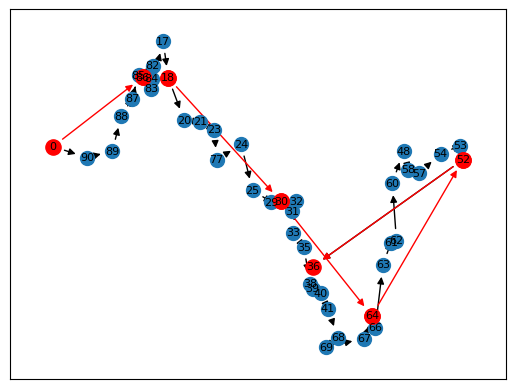

In [127]:
#plot the graph
G = nx.DiGraph()
G.add_nodes_from(N)
G.add_edges_from(path_stages)
nx.draw_networkx_nodes(G, pos=pos, node_size=100, nodelist=N-set(stops))
nx.draw_networkx_labels(G,pos=pos, font_size=8)
stops = tuple(sum(path_stages, ()))
nx.draw_networkx_nodes(G, pos=pos, node_color="red", nodelist=stops, node_size=120)
nx.draw_networkx_edges(G, edgelist=path_edges, pos=pos)
nx.draw_networkx_edges(G, edgelist=path_stages, pos=pos, edge_color="red")

In [ ]:
# parametric analysis



#TO DO


# SPT su grafo da 0 al nodo tc è minimizzato il path
# SPT come fatto in precedenza su grafo ordinato topologicamente come al punto precedente
